# Introduction

### Project initialization and setup

Importing all of the libraries that will be used. In the project.

In [151]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


Connecting the DB to SQL

In [152]:
DB_PATH = "viewer_interactions.db"

try:
    conn = sqlite3.connect(DB_PATH)
    print("Connected successfully!")
except sqlite3.Error as e:
    print("Connection failed:", e)

Connected successfully!


In [153]:
# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

Listing all the tables

In [154]:
tables_query = """
               SELECT name
               FROM sqlite_master
               WHERE type='table'
               ORDER BY name; \
               """

tables_df = pd.read_sql_query(tables_query, conn)
print("Tables in the database:")
display(tables_df)

Tables in the database:


,name
0,data_dictionary
1,movie_statistics
2,movies
3,user_statistics
4,viewer_ratings


Creating a dictionary of type table_name -> DataFrame

In [155]:
table_names = tables_df["name"].tolist()

schemas = {}

for table in table_names:
    pragma_query = f"PRAGMA table_info({table});"
    schema_df = pd.read_sql_query(pragma_query, conn)
    schemas[table] = schema_df
    print(f"\nSchema for table '{table}':")
    display(schema_df)


Schema for table 'data_dictionary':


,cid,name,type,notnull,dflt_value,pk
0,0,table_name,TEXT,0,None,0
1,1,field_name,TEXT,0,None,0
2,2,data_type,TEXT,0,None,0
3,3,description,TEXT,0,None,0



Schema for table 'movie_statistics':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,total_ratings,REAL,0,None,0
2,2,avg_rating,REAL,0,None,0
3,3,std_rating,REAL,0,None,0
4,4,min_rating,REAL,0,None,0
5,5,max_rating,REAL,0,None,0
6,6,unique_users,REAL,0,None,0
7,7,first_rating_date,TEXT,0,None,0
8,8,last_rating_date,TEXT,0,None,0
9,9,year_of_release,REAL,0,None,0



Schema for table 'movies':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,year_of_release,REAL,0,None,0
2,2,title,TEXT,0,None,0



Schema for table 'user_statistics':


,cid,name,type,notnull,dflt_value,pk
0,0,customer_id,INTEGER,0,None,0
1,1,total_ratings,REAL,0,None,0
2,2,avg_rating,REAL,0,None,0
3,3,std_rating,REAL,0,None,0
4,4,min_rating,REAL,0,None,0
5,5,max_rating,REAL,0,None,0
6,6,unique_movies,REAL,0,None,0
7,7,first_rating_date,TEXT,0,None,0
8,8,last_rating_date,TEXT,0,None,0
9,9,activity_days,REAL,0,None,0



Schema for table 'viewer_ratings':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,customer_id,INTEGER,0,None,0
2,2,rating,REAL,0,None,0
3,3,date,TEXT,0,None,0
4,4,anomalous_date,INTEGER,0,None,0


In [156]:
# creating a dictionary to map dataframes
DF_MAP = {}

### Methods

Add new data frame function

In [157]:
def add_new_df(global_name: str, dfs_key: str, dataframe=None):

    # if dataframe already exists in dfs → ignore "dataframe" input
    if dfs_key in dfs:
        globals()[global_name] = dfs[dfs_key]
        DF_MAP[global_name] = dfs_key
        print(f"Mapped existing dfs['{dfs_key}'] to global '{global_name}'")
        return

    # new dataframe
    if dataframe is None:
        raise ValueError(
            f"dfs_key '{dfs_key}' does not exist in dfs and no dataframe was provided."
        )

    dfs[dfs_key] = dataframe
    globals()[global_name] = dataframe
    DF_MAP[global_name] = dfs_key

    print(f"Added NEW df: global '{global_name}' → dfs['{dfs_key}']")

Syn data frame function

In [158]:
def sync_dataframe(*dfs_to_refresh):
    globals_dict = globals()

    for df_obj in dfs_to_refresh:
        updated = False

        for global_name, dfs_key in DF_MAP.items():
            if df_obj is globals_dict[global_name]:
                globals_dict[global_name] = dfs[dfs_key]
                updated = True
                break

        if not updated:
            raise ValueError("Unknown dataframe passed!")

Searching function

In [159]:
# takes the name of the table, the name of the target key, and the value as inputs. Returns singular or multiple dataframes based on the request.

# can also search for null values if value is set to None.

def search_by_parameter(table_name, key, value):
    df = dfs[table_name]

    if value is None:
        return df[df[key].isna()]

    return df[df[key] == value]

In [160]:
# calculates std deviation
# make sure no nulls are included in the calculation!

def manual_std(values):
    arr = np.array(values, dtype=float)

    n = len(arr)

    if n <= 1:
        return 0.0

    mean = arr.mean()
    return np.sqrt(((arr - mean) ** 2).mean())

In [161]:
def covert_string_to_date(date_str):
    if date_str is None or pd.isna(date_str):
        return None
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except:
        return None

In [515]:
def elbow_method(X, k_min=1, k_max=10, random_state=42, plot=True):
    """
    Считает значения inertia для разных k (кол-во кластеров)
    и, при желании, рисует elbow-график.

    X      - матрица признаков (например, X_scaled)
    k_min  - минимальное число кластеров
    k_max  - максимальное число кластеров
    plot   - рисовать ли график
    """

    results = []

    for k in range(k_min, k_max + 1):
        kmeans = KMeans(
            n_clusters=k,
            random_state=random_state,
            n_init=10
        )
        kmeans.fit(X)
        results.append({"k": k, "inertia": kmeans.inertia_})

    elbow_df = pd.DataFrame(results)

    if plot:
        plt.figure()
        plt.plot(elbow_df["k"], elbow_df["inertia"], marker="o")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow method")
        plt.xticks(elbow_df["k"])
        plt.show()

    return elbow_df

### Database initialization

implementing dfs and importing data

In [162]:
dfs = {} # dictionary that maps the name of the table to the related data frame
# isnt it simpler if we just use universal dataframes for each dataset instead of having to worry about dictionaries

for t in table_names:
    df = pd.read_sql_query(f"SELECT * FROM {t};", conn)
    dfs[t] = df
    print(f"\nLoaded table '{t}' with shape {df.shape}")


Loaded table 'data_dictionary' with shape (31, 4)

Loaded table 'movie_statistics' with shape (16015, 11)

Loaded table 'movies' with shape (18008, 3)

Loaded table 'user_statistics' with shape (438780, 10)

Loaded table 'viewer_ratings' with shape (4025000, 5)


In [163]:
# adding our base data frames
add_new_df("movies_stats", "movie_statistics", dfs["movie_statistics"])
add_new_df("movies",       "movies",           dfs["movies"])
add_new_df("user_stats",   "user_statistics",  dfs["user_statistics"])
add_new_df("viewer_ratings", "viewer_ratings", dfs["viewer_ratings"])

Mapped existing dfs['movie_statistics'] to global 'movies_stats'
Mapped existing dfs['movies'] to global 'movies'
Mapped existing dfs['user_statistics'] to global 'user_stats'
Mapped existing dfs['viewer_ratings'] to global 'viewer_ratings'


### Diagnostics

Counting all missing values, diagnostics purposes only

In [539]:
for name, df in dfs.items():
    print(f"\n{name} missing values (%):")
    missing_pct = df.isna().mean() * 100
    display(missing_pct.to_frame("missing_%"))


data_dictionary missing values (%):


,missing_%
table_name,0.0
field_name,0.0
data_type,0.0
description,0.0



movie_statistics missing values (%):


,missing_%
movie_id,0.000000
total_ratings,0.000000
avg_rating,0.830679
std_rating,5.714821
min_rating,0.487165
max_rating,0.512148
unique_users,0.000000
first_rating_date,0.000000
last_rating_date,0.000000
year_of_release,28.174380



movies missing values (%):


,missing_%
movie_id,0.00000
year_of_release,0.03888
title,0.00000



user_statistics missing values (%):


,missing_%
customer_id,0.000000
user_total_ratings,0.000000
user_avg_rating,0.000000
user_std_rating,2.210447
user_min_rating,0.973609
user_max_rating,0.973609
unique_movies,0.000912
user_first_rating_date,0.000000
user_last_rating_date,0.000000
activity_days,0.000000



viewer_ratings missing values (%):


,missing_%
movie_id,0.000000
customer_id,0.000000
rating,10.000007
date,0.000000



movie_full missing values (%):


,missing_%
movie_id,0.000000
movie_total_ratings,0.000000
movie_avg_rating,0.895341
movie_std_rating,5.624131
movie_min_rating,0.521558
movie_max_rating,0.538943
unique_users,0.000000
movie_first_rating_date,0.000000
movie_last_rating_date,0.000000
title,0.000000



merged_data missing values (%):


,missing_%
movie_id,0.0
customer_id,0.0
rating,0.0
date,0.0
user_total_ratings,0.0
user_avg_rating,0.0
user_std_rating,0.0
user_min_rating,0.0
user_max_rating,0.0
unique_movies,0.0



movie_clusters missing values (%):


,missing_%
movie_id,0.0
movie_total_ratings,0.0
movie_avg_rating,0.0
movie_std_rating,0.0
movie_min_rating,0.0
movie_max_rating,0.0
unique_users,0.0
year_of_release,0.0
cluster_id,0.0


In [165]:
missing_after = user_stats[user_stats["std_rating"].isna()].copy()

print("Всего пользователей с NaN std:", len(missing_after))

# 1) Есть ли они вообще в viewer_ratings?
print(
    "Сколько из них встречаются в viewer_ratings:",
    missing_after["customer_id"].isin(viewer_ratings["customer_id"]).sum()
)

Всего пользователей с NaN std: 106252
Сколько из них встречаются в viewer_ratings: 106241


### Movie Statistics Calculations

A function to calculate missing std. ratings of films

In [166]:
# Синхронизируем dataframes
sync_dataframe(movies_stats, viewer_ratings)

# Убираем NaN-рейтинги и считаем std для фильмов
viewer_ratings_clean = viewer_ratings[~viewer_ratings["rating"].isna()]

movie_std = (
    viewer_ratings[~viewer_ratings["rating"].isna()]
    .groupby("movie_id")["rating"]
    .apply(list)
    .reset_index(name="ratings")
)

# manual_std уже объявлена выше и игнорирует NaN (или можно явно указать ignore_nan=True)
movie_std["std_rating"] = movie_std["ratings"].apply(manual_std)
movie_std = movie_std[["movie_id", "std_rating"]]

# Старый процент пропусков
old_null_pct = dfs["movie_statistics"]["std_rating"].isna().mean() * 100

# Мержим новые значения std по movie_id
movies_stats = movies_stats.merge(
    movie_std,
    on="movie_id",
    how="left",
    suffixes=("", "_new")
)

# Обновляем std_rating
movies_stats["std_rating"] = movies_stats["std_rating_new"]
movies_stats.drop(columns=["std_rating_new"], inplace=True)

# Сохраняем обратно
dfs["movie_statistics"] = movies_stats

# Новый процент пропусков
new_null_pct = movies_stats["std_rating"].isna().mean() * 100

# Улучшения
improvement_abs = old_null_pct - new_null_pct
improvement_rel = (improvement_abs / old_null_pct) * 100 if old_null_pct > 0 else 0

print(f"Missing values reduced from {old_null_pct:.2f}% to {new_null_pct:.2f}%.")
print(f"Absolute improvement: {improvement_abs:.2f}%")
print(f"Relative improvement: {improvement_rel:.2f}% better than before.")

Missing values reduced from 57.25% to 5.71%.
Absolute improvement: 51.53%
Relative improvement: 90.02% better than before.


In [167]:
#Figure out how to drop na values in general
movies_stats = dfs['movie_statistics']

print(f"Before cleaning: {len(movies_stats)} movies")
#movies_stats = movies_stats.dropna(subset=['std_rating'])
#dfs['movie_statistics'] = movies_stats
print(f"After removing single-rating movies: {len(movies_stats)} movies")

Before cleaning: 16015 movies
After removing single-rating movies: 16015 movies


Calculating the missing total_ratings of movies

In [168]:
sync_dataframe(movies_stats)

# Collecting all the movies with absent total_rating in a dictionary
missing_dict = {}

missing = search_by_parameter('movie_statistics', 'total_ratings', None)
missing_dict = {row.movie_id: 0 for row in missing.itertuples(index=False)}

# Iterating through viewer_ratings and manually counting the ratings for each film
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id
    if movie_id in missing_dict:
        missing_dict[movie_id] += 1

# Update movie_stats
for row in movies_stats.itertuples(index=True):
    if row.movie_id in missing_dict:
        movies_stats.at[row.Index, "total_ratings"] = missing_dict[row.movie_id]

dfs["movie_statistics"] = movies_stats

Calculating Missing Averages

In [169]:
sync_dataframe(movies_stats, viewer_ratings)

# Finding movies with null avg_rating
missing_avg = search_by_parameter('movie_statistics', 'avg_rating', None)

# Creating a dict of type { movie_id : avg_rating }
# set 0 as base value for now, might change it later
missing_avg_dict = {row.movie_id: 0 for row in missing_avg.itertuples(index=False)}

# Storing the sum of all ratings for each movie
rating_sums = {movie_id: 0 for movie_id in missing_avg_dict}

# Iterating through viewer ratings and adding to sum if movie_id matches
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id
    rating = row.rating

    if movie_id in missing_avg_dict:
        rating_sums[movie_id] += rating

for row in movies_stats.itertuples():
    movie_id = row.movie_id

    if movie_id in rating_sums:
        total = row.total_ratings # I'm assuming that my calculations of total_ratings per movie is correct ang i got rid of                            all null values

        # IF FORE SOME MAGICAL REASON THERE IS STILL A NULL THEN IGNORE
        if pd.isna(total) or total == 0:
            avg = 0
        else:
            avg = rating_sums[movie_id] / total

        movies_stats.at[row.Index, "avg_rating"] = avg

Calculating the missing min and max ratings for movies

In [170]:
sync_dataframe(movies_stats)

# Find movies with missing min_rating and max_rating using your function
missing_min = search_by_parameter('movie_statistics', 'min_rating', None)
missing_max = search_by_parameter('movie_statistics', 'max_rating', None)

# Combine them as some movies may be in both
missing_ids = set(missing_min["movie_id"]) | set(missing_max["movie_id"])

# Take only ratings for the movies we care
relevant_ratings = viewer_ratings[viewer_ratings["movie_id"].isin(missing_ids)]

# Building a nested dict {movie_id : {"min": ..., "max": ...}}
min_max_dict = {}

for row in relevant_ratings.itertuples(index=False):
    movie_id = row.movie_id
    rating = row.rating

    if movie_id not in min_max_dict:
        min_max_dict[movie_id] = {"min": rating, "max": rating}
    else:
        if rating < min_max_dict[movie_id]["min"]:
            min_max_dict[movie_id]["min"] = rating
        if rating > min_max_dict[movie_id]["max"]:
            min_max_dict[movie_id]["max"] = rating

# Update movie_statistics
for row in movies_stats.itertuples(index=True):
    movie_id = row.movie_id

    if movie_id in min_max_dict:
        if pd.isna(row.min_rating):
            movies_stats.at[row.Index, "min_rating"] = min_max_dict[movie_id]["min"]
        if pd.isna(row.max_rating):
            movies_stats.at[row.Index, "max_rating"] = min_max_dict[movie_id]["max"]

dfs["movie_statistics"] = movies_stats

Finding missing unique users

In [171]:
sync_dataframe(movies_stats)

missing_unique = search_by_parameter('movie_statistics', 'unique_users', None)

# creating my favorite movie set
missing_movie_ids = {row.movie_id for row in missing_unique.itertuples(index=False)}

# creating a dict movie_id: customer_id
unique_users_dict = {movie_id: set() for movie_id in missing_movie_ids}

# Gathering unique users
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id

    # as always im getting only those movies which have null for unique users
    if movie_id in unique_users_dict:
        unique_users_dict[movie_id].add(row.customer_id)

# Counting unique users
updated = 0
for movie_id, users in unique_users_dict.items():
    count = len(users)  # unique users count

    movies_stats.loc[
        movies_stats["movie_id"] == movie_id,
        "unique_users"
    ] = count

    updated += 1

# just in case if a movie has 0 ratings im setting unique users to 0
movies_stats["unique_users"] = movies_stats["unique_users"].fillna(0).astype(int)

# Updating
dfs["movie_statistics"] = movies_stats

Checking for any duplicate movie ids and removing them from all datasets to clean the data.

### User_statistics calculations

Calculating user's std rating

In [172]:
sync_dataframe(user_stats)

# grouping by user id
user_std = (
    viewer_ratings[~viewer_ratings["rating"].isna()]
    .groupby("customer_id")["rating"]
    .apply(list)
    .reset_index(name="ratings")
)

user_std["std_rating"] = user_std["ratings"].apply(manual_std)
user_std = user_std[["customer_id", "std_rating"]]

# old percentage
old_null_pct = user_stats["std_rating"].isna().mean() * 100

# merging
user_stats = user_stats.merge(
    user_std,
    on="customer_id",
    how="left",
    suffixes=("", "_new")
)

# replacing old std with new
user_stats["std_rating"] = user_stats["std_rating_new"]
user_stats.drop(columns=["std_rating_new"], inplace=True)

# updating
dfs["user_statistics"] = user_stats

# calculating new percantages
new_null_pct = user_stats["std_rating"].isna().mean() * 100

# calculating improvements
improvement_abs = old_null_pct - new_null_pct
improvement_rel = (improvement_abs / old_null_pct) * 100 if old_null_pct > 0 else 0

print(f"Missing values reduced from {old_null_pct:.2f}% to {new_null_pct:.2f}%.")
print(f"Absolute improvement: {improvement_abs:.2f}%")
print(f"Relative improvement: {improvement_rel:.2f}% better than before.")

Missing values reduced from 24.22% to 2.21%.
Absolute improvement: 22.00%
Relative improvement: 90.87% better than before.


Calculating user's total ratings

In [173]:
sync_dataframe(user_stats)

# Collecting all the users with absent total_ratings
missing_dict = {}

missing = search_by_parameter('user_statistics', 'total_ratings', None)
missing_dict = {row.customer_id: 0 for row in missing.itertuples(index=False)}

# Iterating through viewer_ratings and manually counting the ratings for each user
for row in viewer_ratings.itertuples(index=False):
    if pd.isna(row.rating):
        continue

    customer_id = row.customer_id
    if customer_id in missing_dict:
        missing_dict[customer_id] += 1

# Update user_stats
for row in user_stats.itertuples(index=True):
    if row.customer_id in missing_dict:
        user_stats.at[row.Index, "total_ratings"] = missing_dict[row.customer_id]

dfs["user_statistics"] = user_stats

Calculating user's avg rating

In [174]:
sync_dataframe(user_stats)

# Finding all users with null avg_rating
missing_avg = search_by_parameter('user_statistics', 'avg_rating', None)

# Creating a dict of type { customer_id : avg_rating }
# set 0 as base value
missing_avg_dict = {row.customer_id: 0 for row in missing_avg.itertuples(index=False)}

# Storing the sum of all ratings for each movie
rating_sums = {customer_id: 0 for customer_id in missing_avg_dict}

# Iterating through viewer ratings and adding to sum if movie_id matches
for row in viewer_ratings.itertuples(index=False):
    if pd.isna(row.rating):
        continue

    customer_id = row.customer_id
    rating = row.rating

    if customer_id in missing_avg_dict:
        rating_sums[customer_id] += rating

for row in user_stats.itertuples():
    customer_id = row.customer_id

    if customer_id in rating_sums:
        total = row.total_ratings

        if pd.isna(total) or total == 0:
            avg = 0
        else:
            avg = rating_sums[customer_id] / total

        user_stats.at[row.Index, "avg_rating"] = avg

In [175]:
#activity days
sync_dataframe(user_stats)

missing = search_by_parameter('user_statistics', 'activity_days', None)

# creating a dict
missing_dict = {row.customer_id: 0 for row in missing.itertuples(index=False)}

for row in user_stats.itertuples():
    customer_id = row.customer_id

    if customer_id not in missing_dict: # wroking only with users with missing activity_days
        continue

    first_date = covert_string_to_date(row.first_rating_date)
    last_date = covert_string_to_date(row.last_rating_date)

    # null exception
    if first_date is None or last_date is None:
        continue

    # calcing the difference
    difference = (last_date - last_date).days

    # updating activity_days
    user_stats.at[row.Index, 'activity_days'] = difference

null_percentage = user_stats['activity_days'].isna().mean() * 100
print(f"Missing activity_days: {null_percentage}%")

Missing activity_days: 0.0%


In [176]:
#minmax
sync_dataframe(user_stats)

# Find users with missing min_rating and max_rating using your function
missing_min = search_by_parameter('user_statistics', 'min_rating', None)
missing_max = search_by_parameter('user_statistics', 'max_rating', None)

# Combine them as some users may be in both
missing_ids = set(missing_min["customer_id"]) | set(missing_max["customer_id"])

# Init dictionary for users we need to compute
missing_users = {
    customer_id: {"min": -1, "max": -1} #setting base to -1
    for customer_id in missing_ids
}

for row in viewer_ratings.itertuples(index=False):
    customer_id = row.customer_id
    rating = row.rating

    if customer_id in missing_users:
        # updating min
        if missing_users[customer_id]["min"] == -1 or rating < missing_users[customer_id]["min"]:
            missing_users[customer_id]["min"] = rating

        # updating max
        if missing_users[customer_id]["max"] == -1 or rating > missing_users[customer_id]["max"]:
            missing_users[customer_id]["max"] = rating

# Updating user stats
for row in user_stats.itertuples():
    customer_id = row.customer_id

    if customer_id in missing_users:
        min_val = missing_users[customer_id]["min"]
        max_val = missing_users[customer_id]["max"]

        # if the guy hasn't rated anything im making sure we set min or max to none so we get rid of them in the future
        if min_val == -1 and max_val == -1:
            min_val = None
            max_val = None

        user_stats.at[row.Index, "min_rating"] = min_val
        user_stats.at[row.Index, "max_rating"] = max_val

dfs["user_statistics"] = user_stats

In [177]:
sync_dataframe(user_stats)
missing_unique = search_by_parameter('user_statistics', 'unique_movies', None)

missing_ids = set(missing_unique["customer_id"])

unique_movies_dict = {customer_id: set() for customer_id in missing_ids}

for row in viewer_ratings.itertuples(index=False):
    user_id = row.customer_id
    movie_id = row.movie_id

    if user_id in unique_movies_dict:
        unique_movies_dict[user_id].add(movie_id)

for row in user_stats.itertuples():
    user_id = row.customer_id

    if user_id in unique_movies_dict:
        count_unique = len(unique_movies_dict[user_id])

        if count_unique == 0:
            value = None
        else:
            value = count_unique

        user_stats.at[row.Index, "unique_movies"] = value

# updating
dfs["user_statistics"] = user_stats

### Merging datasets

Merging the Movies and movie statis filling in missing values on either dataset and converting all of the dates to type DateTime as well as all counts and years to integers.
This is in order to clean our movie data before merging it with our user data to fill in any recoverable missing values.
Rows with missing values will be dropped.

In [178]:
movies = dfs['movies'].copy() # does this overwrite the movies we have right now? maybe call it something else.
movie_stats = dfs['movie_statistics'].copy()
viewer_ratings = dfs['viewer_ratings'].copy()

bad_ids_movies = movies.loc[movies['movie_id'].duplicated(keep=False), 'movie_id'].unique().tolist()
bad_ids_stats = movie_stats.loc[movie_stats['movie_id'].duplicated(keep=False), 'movie_id'].unique().tolist()
bad_ids = list(set(bad_ids_movies + bad_ids_stats))
print('bad movie ids to remove: ', bad_ids)

viewer_ratings = viewer_ratings[~viewer_ratings['movie_id'].isin(bad_ids)]
movies = movies[~movies['movie_id'].isin(bad_ids)]
movie_stats = movie_stats[~movie_stats['movie_id'].isin(bad_ids)]

movies['year_of_release'] = (pd.to_numeric(movies['year_of_release'], errors='coerce').astype('Int64'))
movie_stats['total_ratings'] = (pd.to_numeric(movie_stats['total_ratings'], errors='coerce').astype('Int64'))
movie_stats['unique_users'] = (pd.to_numeric(movie_stats['unique_users'], errors='coerce').astype('Int64'))
movie_stats['year_of_release'] = (pd.to_numeric(movie_stats['year_of_release'], errors='coerce').astype('Int64'))

movie_stats['first_rating_date'] = pd.to_datetime(movie_stats['first_rating_date'], errors='coerce')
movie_stats['last_rating_date'] = pd.to_datetime(movie_stats['last_rating_date'], errors='coerce')

# this will automatically remove rows with missing data
movie_full = movies.merge(movie_stats, on='movie_id', how='inner', suffixes=('_movies', '_stats'))

movie_full['title'] = movie_full['title_movies'].combine_first(movie_full['title_stats'])
movie_full['year_of_release'] = movie_full['year_of_release_movies'].combine_first(movie_full['year_of_release_stats'])

movie_full = movie_full.drop(columns=['title_movies', 'title_stats', 'year_of_release_movies', 'year_of_release_stats'])

dfs['movies'] = movies
dfs['movie_statistics'] = movie_stats
dfs['viewer_ratings'] = viewer_ratings
add_new_df('movie_full', 'movie_full', movie_full)

bad movie ids to remove:  [21756, 19549]
Added NEW df: global 'movie_full' → dfs['movie_full']


In [179]:
print("movies dtypes:")
print(movies.dtypes)

print("\nmovie_stats dtypes:")
print(movie_stats.dtypes)

print("\nmovie_full dtypes:")
print(movie_full.dtypes)

movies dtypes:
movie_id            int64
year_of_release     Int64
title              object
dtype: object

movie_stats dtypes:
movie_id                      int64
total_ratings                 Int64
avg_rating                  float64
std_rating                  float64
min_rating                  float64
max_rating                  float64
unique_users                  Int64
first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
year_of_release               Int64
title                        object
dtype: object

movie_full dtypes:
movie_id                      int64
total_ratings                 Int64
avg_rating                  float64
std_rating                  float64
min_rating                  float64
max_rating                  float64
unique_users                  Int64
first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
title                        object
year_of_release               Int64
dtype: object


- Converts the date parameter in viewer_ratings to datetime.
- Merges viewer_ratings, movies, movie_statistics and user_statistics into one dataset as merged_data.

In [180]:
movie_full = dfs['movie_full'].copy()
user_stats = dfs['user_statistics'].copy()
viewer_ratings = dfs['viewer_ratings'].copy()


viewer_ratings['date'] = pd.to_datetime(viewer_ratings['date'], errors = 'coerce')
user_stats['first_rating_date'] = pd.to_datetime(user_stats['first_rating_date'], errors = 'coerce')
user_stats['last_rating_date'] = pd.to_datetime(user_stats['last_rating_date'], errors = 'coerce')

user_stats['total_ratings'] = (pd.to_numeric(user_stats['total_ratings'], errors='coerce').astype('Int64'))
user_stats['unique_movies'] = (pd.to_numeric(user_stats['unique_movies'], errors='coerce').astype('Int64'))
user_stats['activity_days'] = (pd.to_numeric(user_stats['activity_days'], errors='coerce').astype('Int64'))


# create user and movie specific columns
movie_full = movie_full.rename(columns={
    'total_ratings':     'movie_total_ratings',
    'avg_rating':        'movie_avg_rating',
    'std_rating':        'movie_std_rating',
    'min_rating':        'movie_min_rating',
    'max_rating':        'movie_max_rating',
    'first_rating_date': 'movie_first_rating_date',
    'last_rating_date':  'movie_last_rating_date'
})


user_stats = user_stats.rename(columns={
    'total_ratings':     'user_total_ratings',
    'avg_rating':        'user_avg_rating',
    'std_rating':        'user_std_rating',
    'min_rating':        'user_min_rating',
    'max_rating':        'user_max_rating',
    'first_rating_date': 'user_first_rating_date',
    'last_rating_date':  'user_last_rating_date'
})

# drop anomalous date for user stats
if 'anomalous_date' in viewer_ratings.columns:
    viewer_ratings = viewer_ratings.drop(columns=['anomalous_date'])

# merge user stats and viewer ratings
viewer_ratings_with_stats = viewer_ratings.merge(user_stats, on = 'customer_id', how = 'inner')

merged_data = viewer_ratings_with_stats.merge(movie_full, on = 'movie_id', how = 'inner')

# this will drop all rows with any null
merged_data = merged_data.dropna(how = 'any')

add_new_df('merged_data', 'merged_data', merged_data)
dfs['movie_full'] = movie_full
dfs['user_statistics'] = user_stats
dfs['viewer_ratings'] = viewer_ratings

print(merged_data.dtypes)

Added NEW df: global 'merged_data' → dfs['merged_data']
movie_id                            int64
customer_id                         int64
rating                            float64
date                       datetime64[ns]
user_total_ratings                  Int64
user_avg_rating                   float64
user_std_rating                   float64
user_min_rating                   float64
user_max_rating                   float64
unique_movies                       Int64
user_first_rating_date     datetime64[ns]
user_last_rating_date      datetime64[ns]
activity_days                       Int64
movie_total_ratings                 Int64
movie_avg_rating                  float64
movie_std_rating                  float64
movie_min_rating                  float64
movie_max_rating                  float64
unique_users                        Int64
movie_first_rating_date    datetime64[ns]
movie_last_rating_date     datetime64[ns]
title                              object
year_of_release     

### Plotting Statistics and Overall findings

Ryder

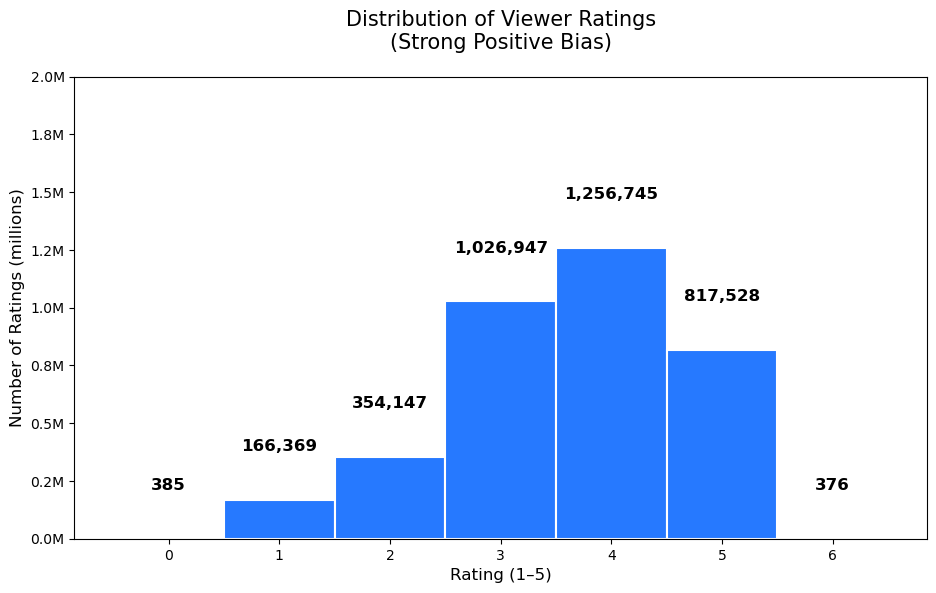

In [181]:
import seaborn as sns


# Markdown cell above
"""
### Global Rating Distribution

There is a clear over positive bias. This can be due to the fact that this was done on a streaming platform where users are more likely to rate higher
"""

plt.figure(figsize=(11, 6)) # made it this size for a better fit in the read me
ax = sns.histplot(
    data=dfs['viewer_ratings'],
    x='rating',
    bins=5,
    discrete=True, #tells seaborn to treat x as integer values
    color="#0062ff",
    edgecolor='white',
    alpha=0.85,  #transparency
    linewidth=1.5
)

# Add exact counts on top of each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2., 
        height + 200_000,                    # a bit above the bar
        f'{int(height):,}',                  # adds commas: 12,345,678
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

# Clean y-axis
plt.ylabel('Number of Ratings (millions)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.title('Distribution of Viewer Ratings\n(Strong Positive Bias)', 
          fontsize=15, pad=20)
plt.xlabel('Rating (1–5)', fontsize=12)
plt.xticks(range(0, 7))
plt.ylim(0, 2_000_000)
plt.show()

In [182]:
"""
### User Average Rating vs. Rating Variability

Scatter from user_statistics: High avg with low std = consistent positive raters. 
Valuable for grouping users (e.g., strict critics vs. easy fans). Alpha for density.
"""

sync_dataframe(user_stats)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_stats, x='avg_rating', y='std_rating', alpha=0.4, color='#0062ff', edgecolor=None)
plt.title('User Average Rating vs. Standard Deviation\n(Rating Consistency Patterns)', fontsize=15, pad=20)
plt.xlabel('Average Rating Given (1–5)', fontsize=12)
plt.ylabel('Std Deviation of Ratings', fontsize=12)
plt.xlim(0, 5)
plt.ylim(0, 4)  # Std typically low due to bias
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

ValueError: Could not interpret value `avg_rating` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

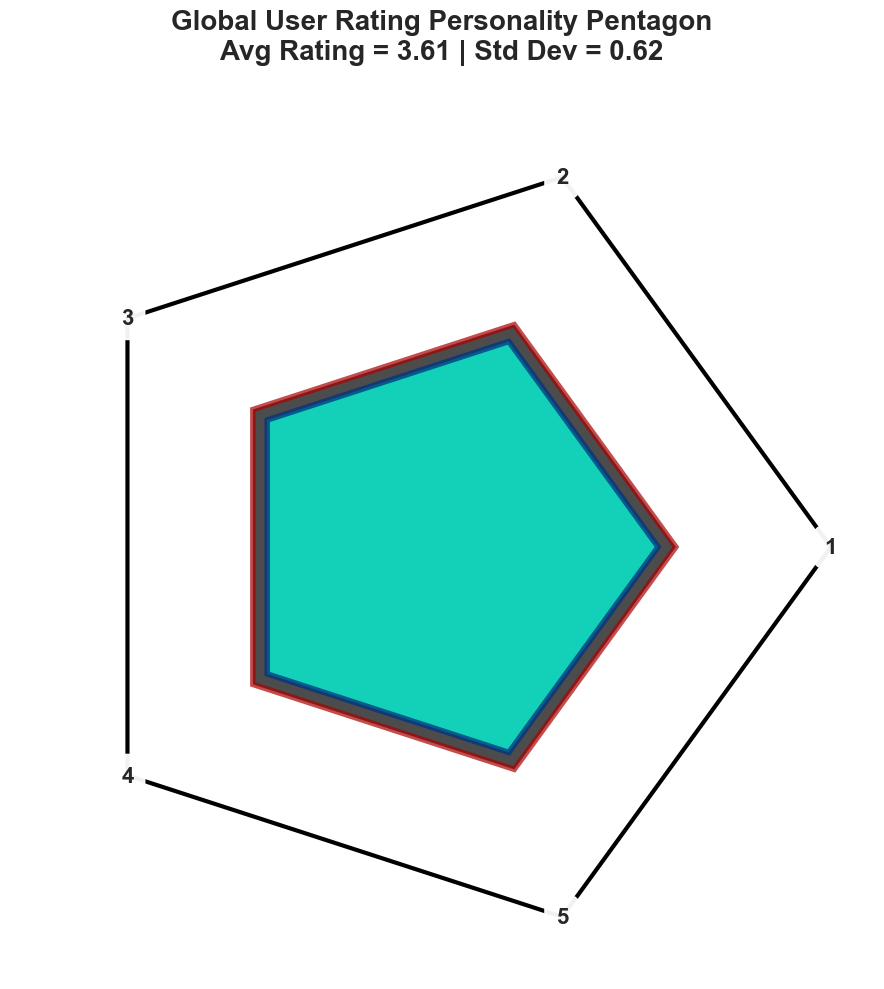

In [ ]:
# PERFECT PENTAGON — FINAL WORKING VERSION (Dec 2025)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# CHANGE ONLY THESE TWO VALUES
avg_rating_value = user_stats['avg_rating'].mean()   # ← your real global avg from user_statistics
std_rating_value = user_stats['std_rating'].mean()   # ← your real global std from user_statistics

# Convert to 0–1 scale
pull_to_five = (avg_rating_value - 1.0) / 4.0
consistency  = np.clip(1.0 - (std_rating_value / 1.8), 0.1, 1.0)

# Pentagon vertices (5 corners + first repeated to close)
center = np.array([0.5, 0.5])
radius = 0.45
angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
verts = center + radius * np.column_stack([np.cos(angles), np.sin(angles)])
verts = np.vstack([verts, verts[0]])  # close the loop → shape (6, 2)

# Blue pentagon (pulled toward Rating 5 = bottom-right)
blue_scale = 0.85 * pull_to_five
blue_verts = center + blue_scale * (verts - center)

# Red pentagon (size = consistency)
red_scale = 0.92 * consistency
red_verts = center + red_scale * (verts - center)

# Correct Path codes: 6 vertices → 6 codes
codes = [Path.MOVETO] + [Path.LINETO]*4 + [Path.CLOSEPOLY]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Outer frame
frame_path = Path(verts, codes)
ax.add_patch(PathPatch(frame_path, facecolor='none', edgecolor='black', linewidth=3))

# Red pentagon (consistency)
red_path = Path(red_verts, codes)
ax.add_patch(PathPatch(red_path, facecolor="#000000", alpha=0.7, edgecolor='#aa0000', linewidth=4))

# Blue pentagon (average rating)
blue_path = Path(blue_verts, codes)
ax.add_patch(PathPatch(blue_path, facecolor="#00ffdd", alpha=0.75, edgecolor='#003380', linewidth=4))

# Corner labels
labels = ['1', '2', '3', '4', '5']
for (x, y), label in zip(verts[:-1], labels):
    ax.text(x, y, label, fontsize=16, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')

ax.set_title(f"Global User Rating Personality Pentagon\n"
             f"Avg Rating = {avg_rating_value:.2f} | Std Dev = {std_rating_value:.2f}",
             fontsize=20, pad=40, fontweight='bold')

plt.tight_layout()
plt.show()

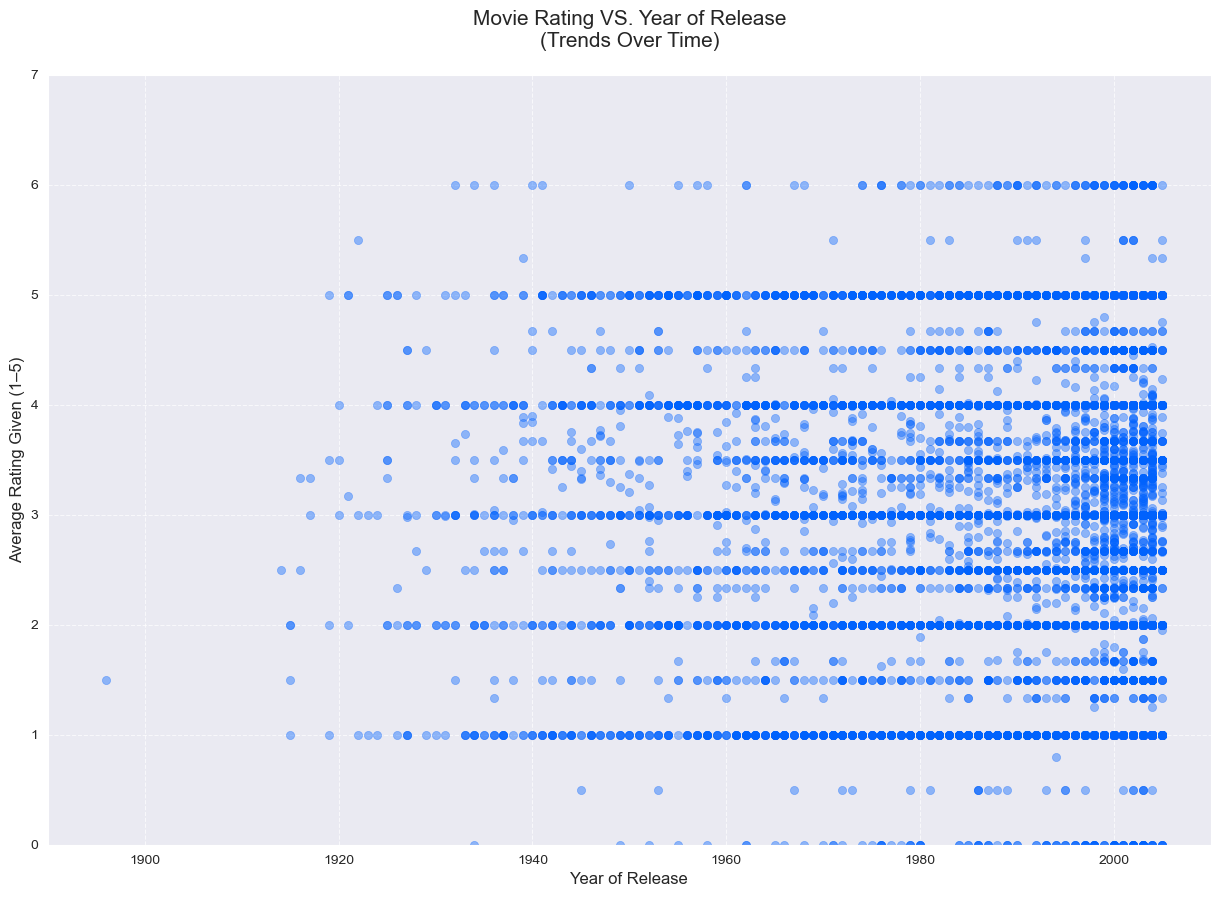

In [ ]:
'Plotting a timeline of ratings over time'

sync_dataframe(movies_stats)

plt.figure(figsize=(15, 10))
sns.scatterplot(data=movies_stats, x='year_of_release', y='avg_rating', alpha=0.4, color='#0062ff', edgecolor=None, s=35)
plt.title('Movie Rating VS. Year of Release\n(Trends Over Time)', fontsize=15, pad=20)
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Average Rating Given (1–5)', fontsize=12)
plt.xlim(1890, 2010) #this included the data for all the movies in the data set as it goes from 1896 to 2005
plt.ylim(0, 7)  
#plt.scatter(x,y, s)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def get_top_rated_movies(min_ratings=100, top_n=10):
    """
    Returns the top N best-rated movies with at least min_ratings.
    Merges movie_statistics and movies tables to get titles and years.
    """
    # Get movie stats and filter
    sync_dataframe(movies_stats)
    filtered = movies_stats[movies_stats['total_ratings'] >= min_ratings]
    
    # Sort by avg_rating descending
    top_movies = filtered.sort_values('avg_rating', ascending=False).head(top_n)
    
    # Select and reorder columns nicely
    result = top_movies[['movie_id', 'avg_rating', 'total_ratings']].copy()
    
    result = result.reset_index(drop=True)
    result.index = result.index + 1  # Start ranking at 1
    
    return result

# === USE IT LIKE THIS ===
print("TOP 10 BEST-RATED MOVIES (min 100 ratings):")
display(get_top_rated_movies(min_ratings=200, top_n=10))

# sync_dataframe(movies_stats)

# plt.figure(figsize=(15, 10))
# sns.scatterplot(data=get_top_rated_movies(min_ratings=100, top_n=10), x='movie_id', y='avg_rating', alpha=0.4, color='#0062ff', edgecolor=None, s=35)
# plt.title('top 10 best-rated movies (min 100 ratings)', fontsize=15, pad=20)
# plt.xlabel('Movies', fontsize=12)
# plt.ylabel('Average Rating Given (1–5)', fontsize=12)
# plt.xlim(str(search_by_parameter("movies", "movie_id", get_top_rated_movies(min_ratings=100, top_n=10)['movie_id'].min())["title"]), str(search_by_parameter("movies", "movie_id", get_top_rated_movies(min_ratings=100, top_n=10)['movie_id'].max())["title"])) #this included the data for all the movies in the data set as it goes from 1896 to 2005
# plt.ylim(0, 5)  
# #plt.scatter(x,y, s)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

print(str(search_by_parameter("movies", "movie_id", get_top_rated_movies(min_ratings=200, top_n=10)['movie_id'].min())["title"]))

# ploting = []
# for ploting.len() in range(10):
#     ploting.append([search_by_parameter("movies", "movie_id", get_top_rated_movies(min_ratings=100, top_n=10)['movie_id'])])

# print("here"+ploting(1))

TOP 10 BEST-RATED MOVIES (min 100 ratings):


,movie_id,avg_rating,total_ratings
1,13504,4.522613,1592
2,9436,4.450363,413
3,85,4.231343,268
4,13468,4.223117,3106
5,223,4.211008,24127
6,9326,4.194849,7688
7,13499,4.180188,2231
8,33,4.168336,6891
9,209,4.160951,4374
10,4633,4.146189,41850


32    Aqua Teen Hunger Force: Vol. 1
Name: title, dtype: object


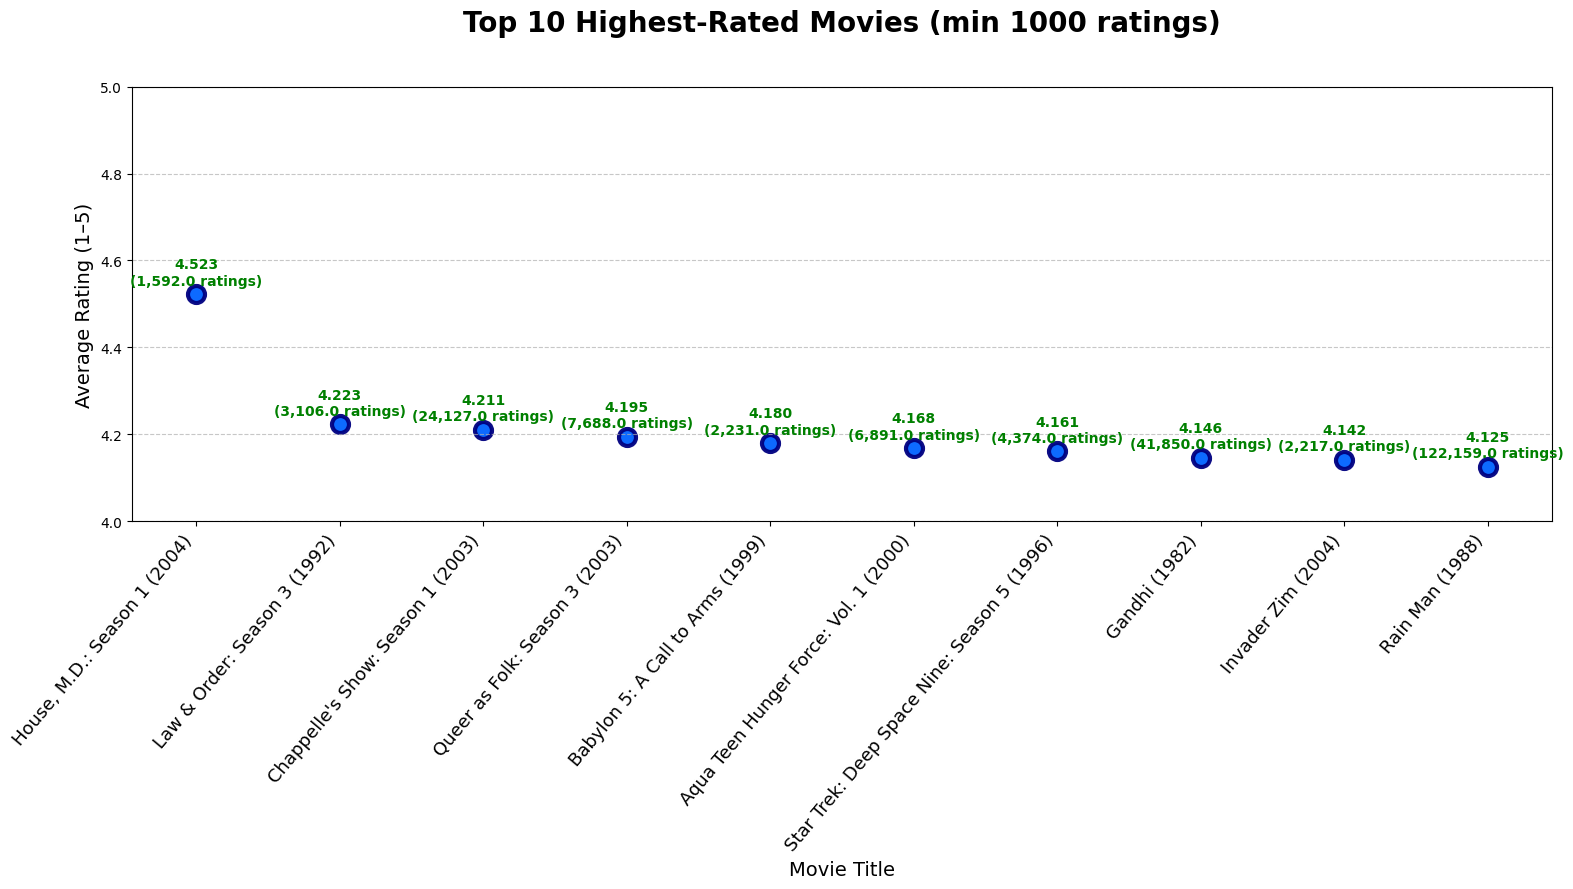

Top 10 Movies (no merge):


,title_display,avg_rating,total_ratings,movie_id
1,"House, M.D.: Season 1 (2004)",4.522613,1592.0,13504
2,Law & Order: Season 3 (1992),4.223117,3106.0,13468
3,Chappelle's Show: Season 1 (2003),4.211008,24127.0,223
4,Queer as Folk: Season 3 (2003),4.194849,7688.0,9326
5,Babylon 5: A Call to Arms (1999),4.180188,2231.0,13499
6,Aqua Teen Hunger Force: Vol. 1 (2000),4.168336,6891.0,33
7,Star Trek: Deep Space Nine: Season 5 (1996),4.160951,4374.0,209
8,Gandhi (1982),4.146189,41850.0,4633
9,Invader Zim (2004),4.142084,2217.0,68
10,Rain Man (1988),4.125255,122159.0,4640


In [148]:
def get_top_rated_movies(min_ratings=200, top_n=10):
    sync_dataframe(movies_stats)
    
    # Filter and sort — pure movie_statistics
    filtered = movies_stats[movies_stats['total_ratings'] >= min_ratings]
    top_movies = filtered.sort_values('avg_rating', ascending=False).head(top_n).copy()
    
    # Reset index to get ranking 1 to 10
    top_movies = top_movies.reset_index(drop=True)
    top_movies.index = top_movies.index + 1
    
    # Use your existing search function to get titles
    titles = []
    for movie_id in top_movies['movie_id']:
        result = search_by_parameter("movies", "movie_id", movie_id)
        title = result['title'].iloc[0] if not result.empty else f"Unknown ({movie_id})"
        year = int(result['year_of_release'].iloc[0]) if not result.empty and pd.notna(result['year_of_release'].iloc[0]) else ""
        titles.append(f"{title} ({year})" if year else title)
    
    top_movies['title_display'] = titles
    return top_movies

# === GET DATA ===
top10 = get_top_rated_movies(min_ratings=1000, top_n=10)

# === PLOT — TITLES ON X-AXIS (FIXED & WORKING) ===
plt.figure(figsize=(16, 9))

# Scatter plot with titles
sns.scatterplot(
    data=top10,
    x='title_display',
    y='avg_rating',
    s=150,
    color='#0062ff',
    edgecolor='navy',
    alpha=0.95,
    linewidth=3
)

# Add text above each point
for i, row in top10.iterrows():
    plt.text(
        x=i-1,  # categorical position
        y=row['avg_rating'] + 0.015,
        s=f"{row['avg_rating']:.3f}\n({row['total_ratings']:,} ratings)",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='green'
    )

plt.title('Top 10 Highest-Rated Movies (min 1000 ratings)', 
          fontsize=20, pad=40, fontweight='bold')
plt.xlabel('Movie Title', fontsize=14)
plt.ylabel('Average Rating (1–5)', fontsize=14)
plt.ylim(4.0, 5.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=50, ha='right', fontsize=13)

plt.tight_layout()
plt.show()

# Display table
print("Top 10 Movies (no merge):")
display(top10[['title_display', 'avg_rating', 'total_ratings', 'movie_id']])

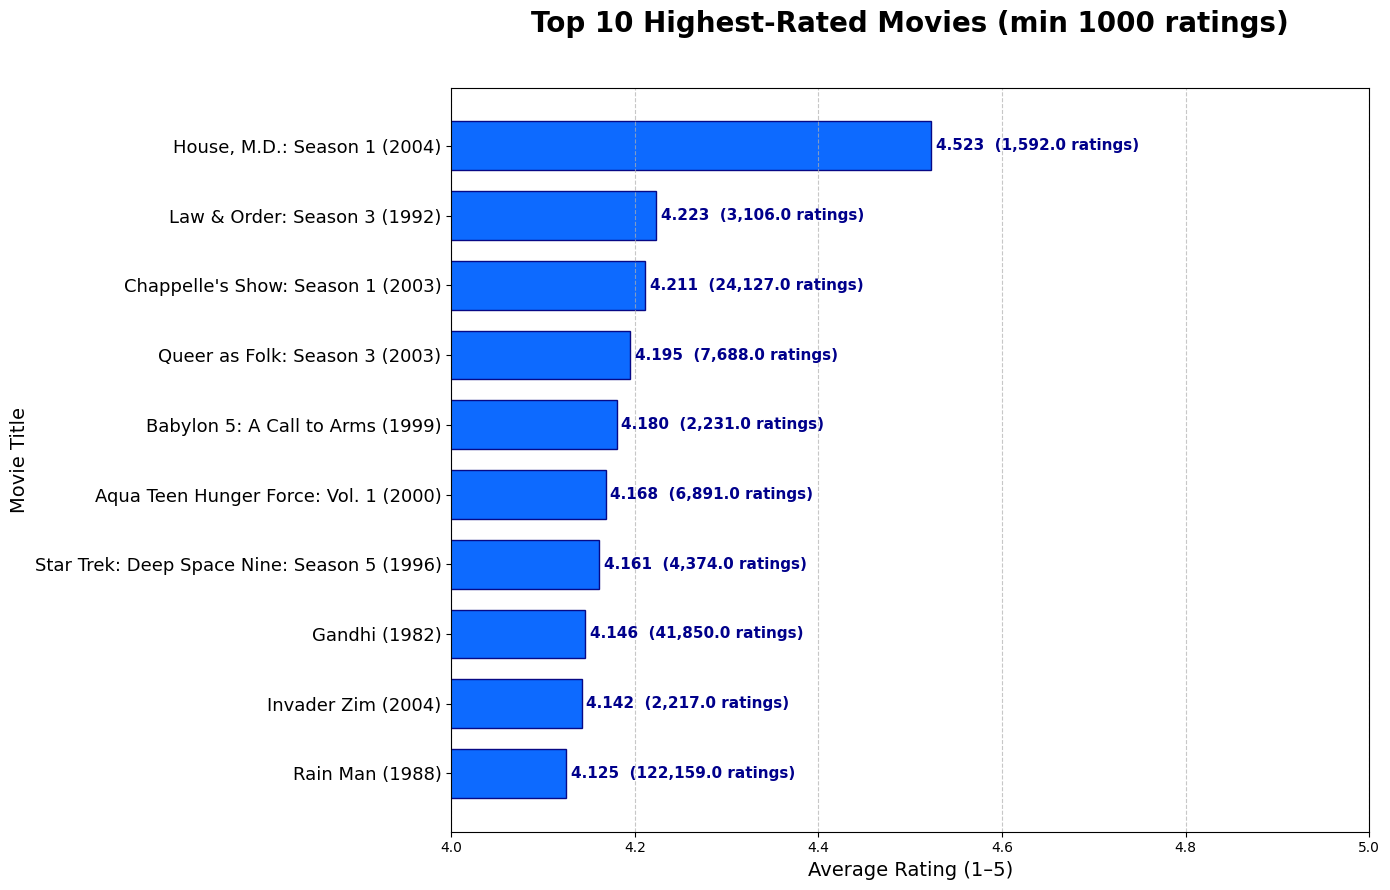

In [149]:
plt.figure(figsize=(14, 9))

top10_Reversed = top10.sort_values('avg_rating', ascending=True)

bars = plt.barh(
    y=top10_Reversed['title_display'],
    width=top10_Reversed['avg_rating'],
    color='#0062ff',
    edgecolor='navy',
    height=0.7,
    alpha=0.95
)

# Add the exact rating + number of ratings on each bar
for bar, row in zip(bars, top10_Reversed.itertuples()):
    plt.text(
        x=bar.get_width() + 0.005,                    # slightly right of bar
        y=bar.get_y() + bar.get_height()/2,           # center vertically
        s=f"{row.avg_rating:.3f}  ({row.total_ratings:,} ratings)",
        va='center',
        ha='left',
        fontsize=11,
        fontweight='bold',
        color='darkblue'
    )

# Styling — same as your scatterplot
plt.title('Top 10 Highest-Rated Movies (min 1000 ratings)', 
          fontsize=20, pad=40, fontweight='bold')
plt.xlabel('Average Rating (1–5)', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.xlim(4.0, 5.0)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Clean y-axis labels (movie titles)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()

 ### Work in progress/Miscellaneous

Giacomo's Ting

In [ ]:
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';",
    conn
    )['name'].tolist()

print("=== DATA DICTIONARY ===\n")

for table in tables:
    print(f"Table: {table}")
    print("-" * (7 + len(table)))

    # Get actual column info from PRAGMA but filter to nice output
    schema = pd.read_sql(f"PRAGMA table_info('{table}')", conn)

    # Keep only real schema fields you want (remove cid, default, pk if desired)
    clean_schema = schema[['name', 'type', ]]

    print(clean_schema.to_string(index=False))
    print("\n")

=== DATA DICTIONARY ===

Table: viewer_ratings
---------------------
          name    type
      movie_id INTEGER
   customer_id INTEGER
        rating    REAL
          date    TEXT
anomalous_date INTEGER


Table: movies
-------------
           name    type
       movie_id INTEGER
year_of_release    REAL
          title    TEXT


Table: user_statistics
----------------------
             name    type
      customer_id INTEGER
    total_ratings    REAL
       avg_rating    REAL
       std_rating    REAL
       min_rating    REAL
       max_rating    REAL
    unique_movies    REAL
first_rating_date    TEXT
 last_rating_date    TEXT
    activity_days    REAL


Table: movie_statistics
-----------------------
             name    type
         movie_id INTEGER
    total_ratings    REAL
       avg_rating    REAL
       std_rating    REAL
       min_rating    REAL
       max_rating    REAL
     unique_users    REAL
first_rating_date    TEXT
 last_rating_date    TEXT
  year_of_release    RE

### Models

Markdown

   movie_id  movie_total_ratings  movie_avg_rating  movie_std_rating  movie_min_rating  movie_max_rating  \
0         1                  548          3.744526          1.089920               1.0               5.0   
1         2                  146          3.547945          1.279922               1.0               5.0   
2         3                 2013          3.639841          0.977014               1.0               5.0   
3         4                  142          2.739437          1.279748               1.0               5.0   
4         5                 1140          3.919298          1.288186               1.0               5.0   

   unique_users  year_of_release  
0           548             2003  
1           146             2004  
2          2013             1997  
3           142             1994  
4          1140             2004  
cluster_id
0    4434
1    3249
2    3027
3      19
Name: count, dtype: int64
Mapped existing dfs['movie_clusters'] to global 'movie_clusters'

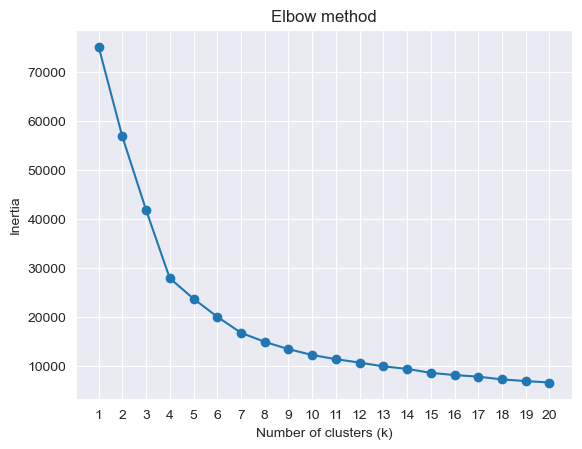

     k       inertia
0    1  75103.000000
1    2  56778.398203
2    3  41832.593729
3    4  27909.298573
4    5  23735.684575
5    6  20071.561740
6    7  16798.251053
7    8  14955.258469
8    9  13467.773325
9   10  12277.316605
10  11  11423.262035
11  12  10723.188119
12  13   9959.493581
13  14   9449.027213
14  15   8633.498423
15  16   8190.293551
16  17   7858.409792
17  18   7299.527334
18  19   6966.909005
19  20   6669.640891


,movie_id,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,unique_users,year_of_release,cluster_id,title
0,30,118413,3.761842,0.938281,1.0,5.0,118413,2003,3,Something's Gotta Give
1,175,90451,4.003814,1.019408,1.0,5.0,90451,1992,3,Reservoir Dogs
2,191,98720,3.932202,0.892798,1.0,5.0,98720,2003,3,X2: X-Men United
3,197,81262,3.478945,0.989632,1.0,5.0,81262,2004,3,Taking Lives
4,4577,106295,3.857679,1.084833,1.0,5.0,106294,1989,3,Steel Magnolias
5,4590,78721,3.342577,1.005924,1.0,5.0,78721,2004,3,The Forgotten
6,4640,122159,4.125255,0.823140,1.0,5.0,122159,1988,3,Rain Man
7,4656,130783,3.813454,0.931994,1.0,5.0,130783,2000,3,Erin Brockovich
8,4661,51392,3.252043,1.099240,1.0,5.0,51392,1999,3,Deuce Bigalow: Male Gigolo
9,9254,72884,4.013720,0.998139,1.0,5.0,72884,1985,3,The Goonies


In [538]:
sync_dataframe(merged_data)
#marco
merged = dfs["merged_data"]

# feautures im basing my clusters on
movie_features = [
    "movie_total_ratings",
    "movie_avg_rating",
    "movie_std_rating",
    "movie_min_rating",
    "movie_max_rating",
    "unique_users",
    "year_of_release",
]

# making a table 1 row - 1 movie
movies_for_clustering = (
    merged
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

print(movies_for_clustering.head())

# getting all number variables except for movie_id
X = movies_for_clustering[movie_features].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# number of clusters
n_clusters = 4

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X_scaled)

# adding cluster ids to the table
movies_for_clustering["cluster_id"] = cluster_labels

# printing how many movies in each cluster, only for debugging
print(movies_for_clustering["cluster_id"].value_counts().sort_index())

# saving
add_new_df('movie_clusters', 'movie_clusters', movies_for_clustering)

# X_scaled из предыдущего шага (после StandardScaler)
elbow_df = elbow_method(X_scaled, 1, 20)
print(elbow_df)

small_cluster = movies_for_clustering[movies_for_clustering["cluster_id"] == 3]
small_cluster.describe()
small_cluster.merge(merged[["movie_id", "title"]].drop_duplicates(), on="movie_id")

Markdown

cluster_id
0    4434
1    3249
2    2971
3      56
Name: count, dtype: int64


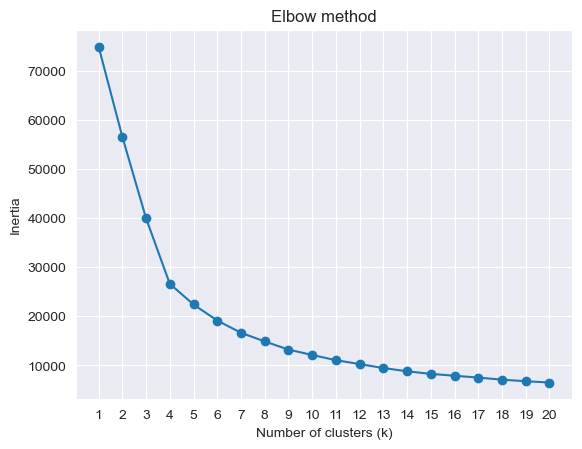

     k       inertia
0    1  74970.000000
1    2  56602.053753
2    3  39989.883385
3    4  26628.839754
4    5  22414.558355
5    6  19141.566848
6    7  16654.024623
7    8  14883.109157
8    9  13229.484246
9   10  12120.197174
10  11  11068.278718
11  12  10271.476299
12  13   9467.860831
13  14   8801.793212
14  15   8275.791565
15  16   7896.992318
16  17   7517.931824
17  18   7097.012853
18  19   6772.944101
19  20   6515.405531
Статистика по кластеру: 3


,movie_id,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,unique_users,year_of_release,cluster_id
count,56.000000,56.0,56.000000,56.000000,56.000000,56.000000,56.0,56.0,56.0
mean,7202.625000,22433.928571,3.550218,1.014186,0.982143,5.017857,22433.928571,1992.303571,3.0
std,5180.456223,8428.750691,0.319375,0.092142,0.133631,0.133631,8428.750691,12.647558,0.0
min,8.000000,11509.0,2.852868,0.851824,0.000000,5.000000,11509.0,1940.0,3.0
25%,217.000000,15034.5,3.358113,0.951919,1.000000,5.000000,15034.5,1985.0,3.0
50%,9241.000000,19943.0,3.515663,0.997172,1.000000,5.000000,19943.0,1996.5,3.0
75%,13379.500000,27282.5,3.818825,1.077453,1.000000,5.000000,27282.5,2001.25,3.0
max,13511.000000,41850.0,4.211008,1.313817,1.000000,6.000000,41850.0,2005.0,3.0



Фильмы в кластере 3:


,movie_id,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,unique_users,year_of_release,cluster_id,title
0,8,14912,3.189646,1.313817,1.0,5.0,14912,2004,3,What the #$*! Do We Know!?
1,28,39753,3.823259,0.973327,1.0,5.0,39753,2002,3,Lilo and Stitch
2,58,17406,3.611858,0.952767,1.0,5.0,17406,1996,3,Dragonheart
3,77,13600,2.852868,1.127461,1.0,6.0,13600,1995,3,Congo
4,83,18724,3.729331,0.862216,1.0,5.0,18724,1983,3,Silkwood
5,97,11509,3.871753,0.904742,1.0,5.0,11509,2002,3,Mostly Martha
6,108,19021,3.167026,0.948139,1.0,5.0,19021,2004,3,Spartan
7,111,30128,3.082813,0.994060,1.0,5.0,30128,2003,3,Duplex (Widescreen)
8,118,19241,3.432774,1.094885,0.0,5.0,19241,1985,3,Rambo: First Blood Part II
9,143,38365,3.853095,0.921530,1.0,5.0,38365,1997,3,The Game


In [535]:
# фильмы, которые НЕ входят в маленький кластер
valid_movie_ids = movies_for_clustering[movies_for_clustering["cluster_id"] != 3]["movie_id"]

# новый merged, очищенный от кластера 3
merged_clean = merged[merged["movie_id"].isin(valid_movie_ids)].copy()

movie_features = [
    "movie_total_ratings",
    "movie_avg_rating",
    "movie_std_rating",
    "movie_min_rating",
    "movie_max_rating",
    "unique_users",
    "year_of_release",
]

movies_clean = (
    merged_clean
    .groupby("movie_id")[movie_features]
    .first()
    .reset_index()
)

from sklearn.preprocessing import StandardScaler

X_clean = movies_clean[movie_features].astype(float)

scaler_clean = StandardScaler()
X_clean_scaled = scaler_clean.fit_transform(X_clean)

from sklearn.cluster import KMeans

kmeans_clean = KMeans(
    n_clusters=4,     # оставляем то же k
    random_state=42,
    n_init=10
)

labels_clean = kmeans_clean.fit_predict(X_clean_scaled)

movies_clean["cluster_id"] = labels_clean

print(movies_clean["cluster_id"].value_counts().sort_index())

elbow_df = elbow_method(X_clean_scaled, 1, 20)
print(elbow_df)

def inspect_cluster(movies_df, merged_df, cluster_id):
    """
    movies_df — таблица с movie_id и cluster_id (movies_clean)
    merged_df — merged или merged_clean с колонками movie_id + title
    cluster_id — номер кластера, который нужно изучить
    """
    cluster = movies_df[movies_df["cluster_id"] == cluster_id]

    print("Статистика по кластеру:", cluster_id)
    display(cluster.describe())

    detailed = cluster.merge(
        merged_df[["movie_id", "title"]].drop_duplicates(),
        on="movie_id",
        how="left"
    )

    print(f"\nФильмы в кластере {cluster_id}:")
    return detailed

inspect_cluster(movies_clean, merged_clean, 3)


In [ ]:
#r

In [ ]:
#r

In [ ]:
#m

In [ ]:
#m

K-means on users

In [ ]:
features = ['user_total_ratings', 'user_unique_movies', 'user_activity_days', 'user_avg_rating', 'user_std_rating']

Markdown

In [ ]:
#giacomo

In [ ]:
#g

In [ ]:
#g